In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import pyro

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import scipy.stats as stats 

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
from pyro.infer import MCMC, NUTS

In [3]:
business_df = pd.read_csv('../datasets/Transformed_Dataset.csv')

In [32]:
business_df.shape

(300153, 26)

have histograms based if it is economy class


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

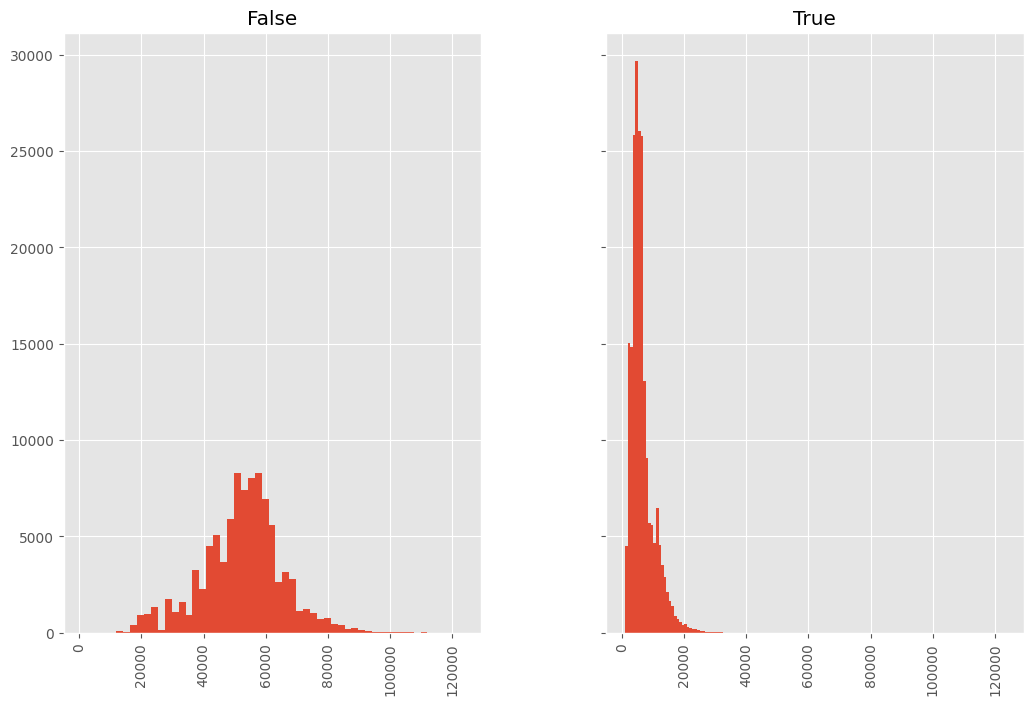

In [33]:
print('have histograms based if it is economy class')

business_df.hist('price', bins=50, by=business_df['Economy'], sharey=True, sharex=True)

array([[<Axes: title={'center': 'price'}>]], dtype=object)

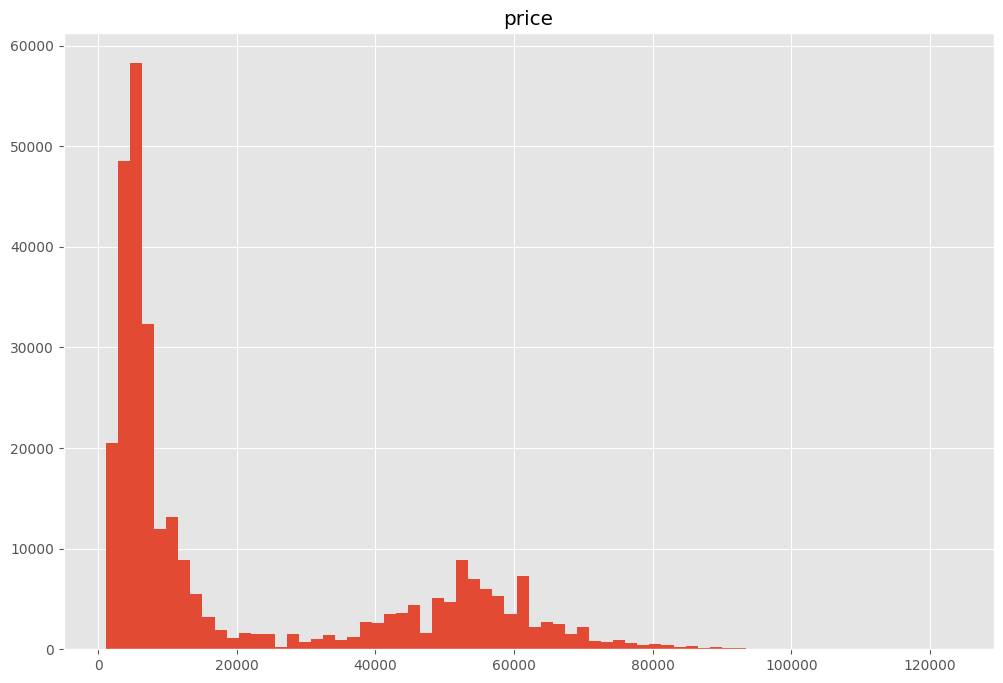

In [34]:
business_df.hist('price', bins=70)

In [35]:
train_x, test_x, train_y,test_y = train_test_split(business_df['Economy'], business_df['price'], test_size=0.5, random_state=488)

x_train_clean = torch.tensor(train_x.to_numpy(dtype=np.int_)) #business_df['Economy']
y_train_clean = torch.tensor(train_y.values)

x_test_clean = torch.tensor(test_x.to_numpy(dtype=np.int_)) #business_df['Economy']
y_test_clean = torch.tensor(test_y.values)

In [38]:
x_train_clean.count_nonzero(), len(x_train_clean)

(tensor(103144), 150076)

In [39]:
# # priors for components
# mu_loc = torch.tensor([4500., 55000.])
# mu_scale = torch.tensor([100., 100.])
# sigma_scale = torch.tensor([10., 10.])
# with pyro.plate('components', 2):
#     mu = pyro.sample('mu', pyro.distributions.Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
#     sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
    
# #with pyro.plate('data', len(y)):
# #    #buss = pyro.sample('busi', pyro.distributions.Bernoulli(x), infer={"enumerate":"parallel"}).long()
# #    buss = x
# #    price = pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]), obs=y)

In [40]:
# buss = 0
# pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]))

In [41]:
def first_model(x=None, y=None):
    # priors for components
    #pi = pyro.sample('pi', pyro.distributions.Beta(2.,2.))
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([1., 1.])
    sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        mu = pyro.sample('mu', pyro.distributions.Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
        
    with pyro.plate('data', len(y)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(pi), infer={"enumerate":"parallel"}).long()
        buss = x
        price = pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]), obs=y)
    
    return price
    

In [42]:
def first_model(x=None, y=None):
    # priors for components
    #pi = pyro.sample('pi', pyro.distributions.Beta(2.,2.))
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([3., 3.])
    sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        mu = pyro.sample('mu', pyro.distributions.HalfCauchy(mu_scale))#Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
        
    with pyro.plate('data', len(y)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(pi), infer={"enumerate":"parallel"}).long()
        buss = x
        #price = pyro.sample('price', pyro.distributions.Chi2(mu[buss]), obs=y)
        price = pyro.sample('price', pyro.distributions.Gamma(mu[buss],sigma[buss]), obs=y)
    
    return price

In [43]:
# Run inference in Pyro
nuts_kernel = NUTS(first_model)
mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=200, num_chains=1)
mcmc.run(x_train_clean,y_train_clean)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 600/600 [03:16,  3.05it/s, step size=5.91e-02, acc. prob=0.904]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]     14.21      0.08     14.22     14.08     14.36    178.95      1.00
     mu[1]      3.73      0.02      3.73      3.70      3.77    123.65      1.00
  sigma[0]      0.00      0.00      0.00      0.00      0.00    180.75      1.00
  sigma[1]      0.00      0.00      0.00      0.00      0.00    111.44      1.00

Number of divergences: 0


In [44]:
posterior_samples = mcmc.get_samples()
print(posterior_samples.keys())

dict_keys(['mu', 'sigma'])


## first attempt:

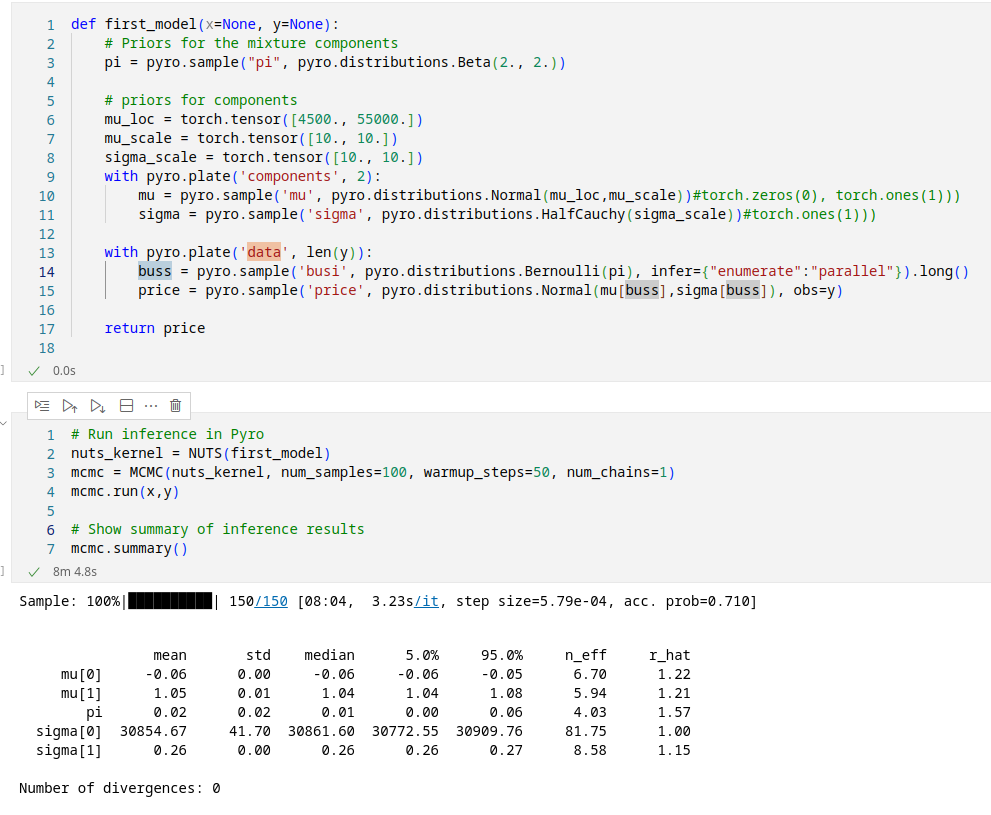

## second attempt:
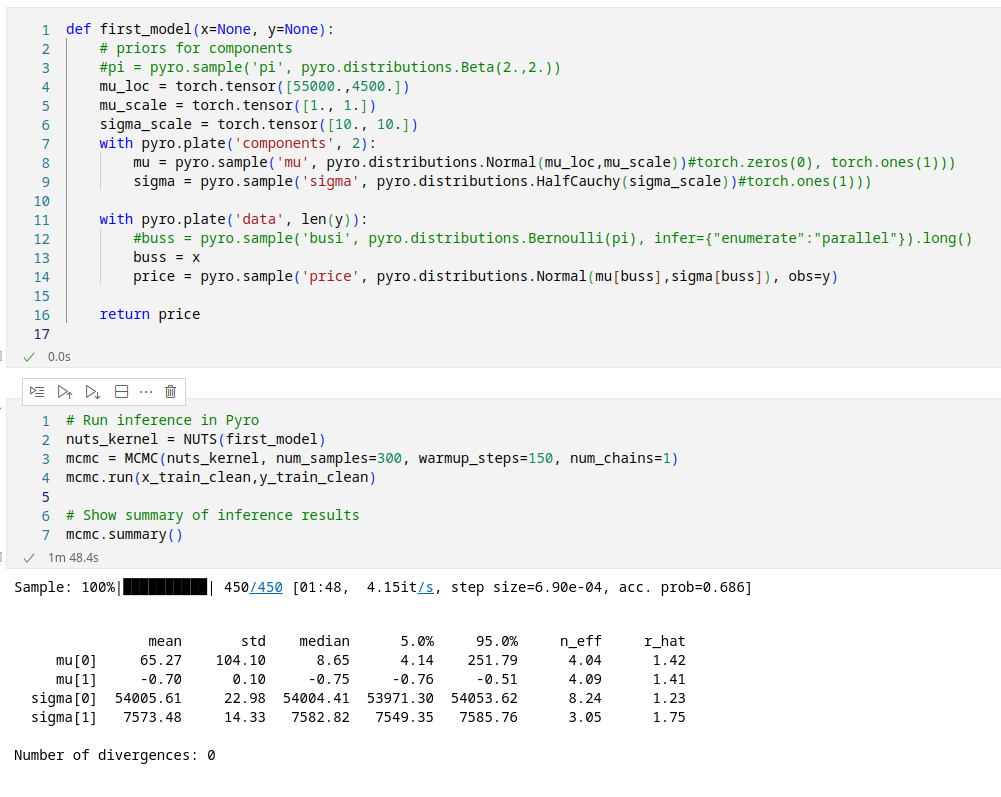

## third attempt
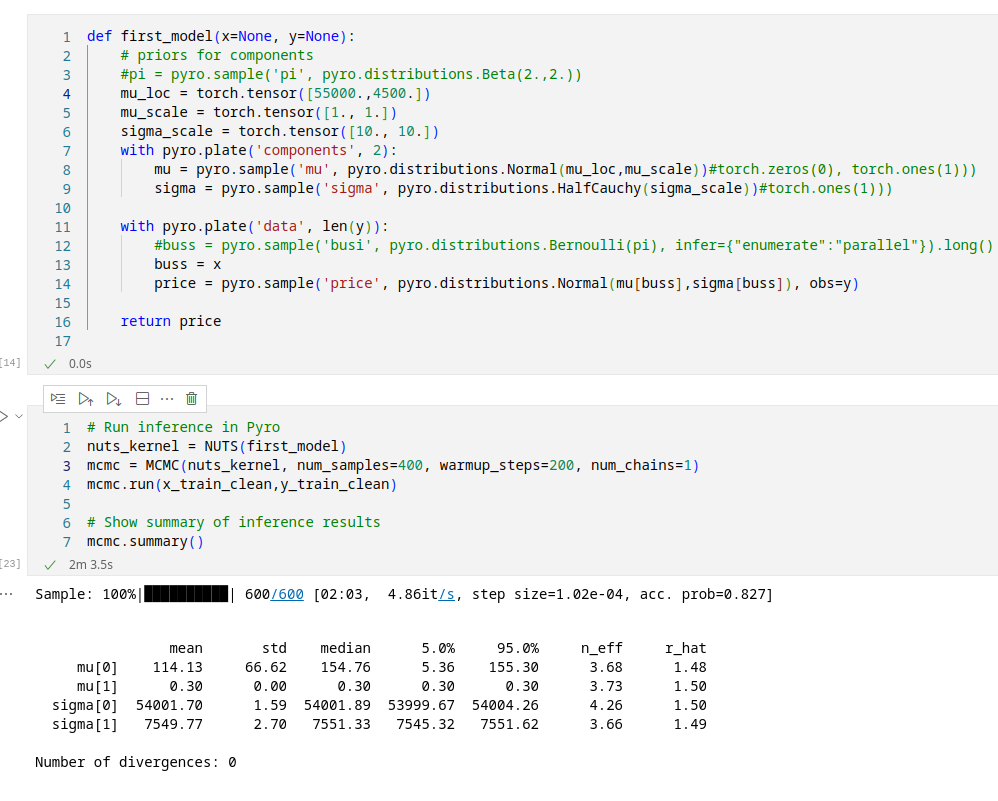

## trying out Gamma
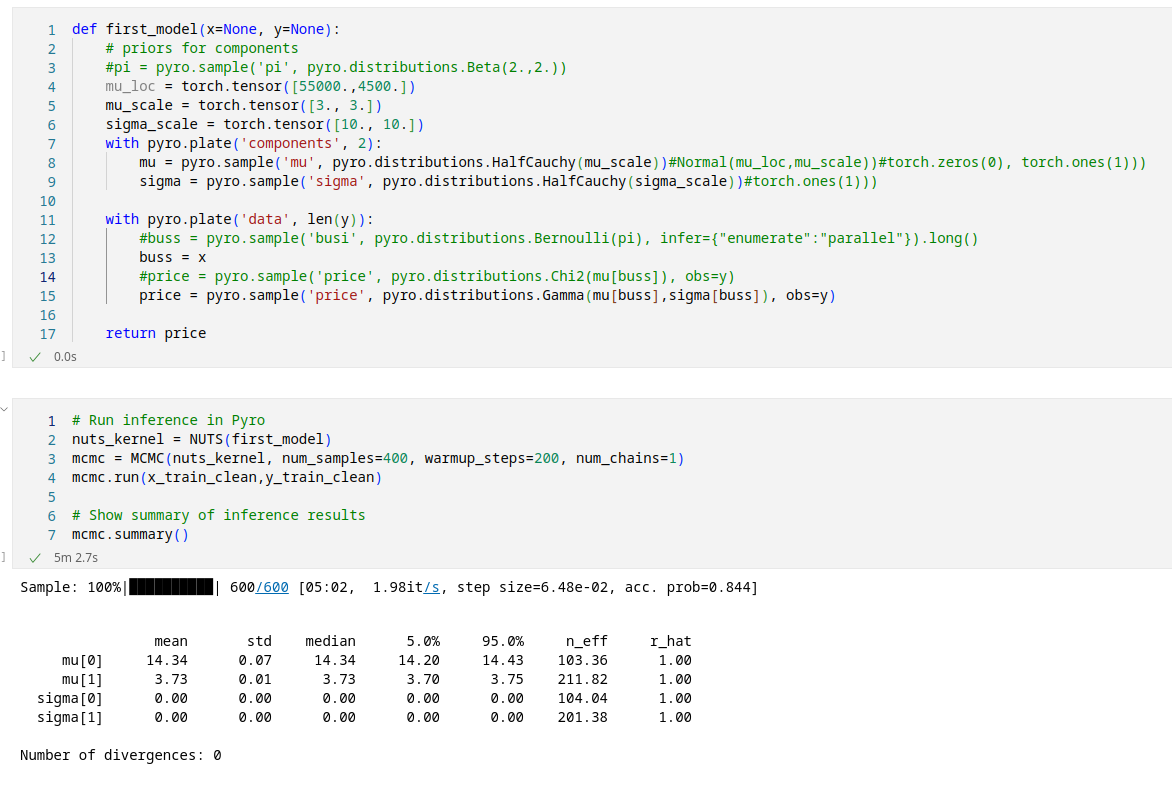

# make predictions

In [45]:
def first_model_pred(x=None, y=None):
    # priors for components
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([1., 1.])
    sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        mu = pyro.sample('mu', pyro.distributions.Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
        
    with pyro.plate('data', len(y)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(x), infer={"enumerate":"parallel"}).long()
        buss = x
        price = pyro.sample('price', pyro.distributions.Normal(mu[buss],sigma[buss]), obs=y)
    price_pred = pyro.sample('price_pred', pyro.distributions.Normal(mu[buss],sigma[buss]))
    return price_pred

In [46]:
def first_model(x=None, y=None):
    # priors for components
    #pi = pyro.sample('pi', pyro.distributions.Beta(2.,2.))
    mu_loc = torch.tensor([55000.,4500.])
    mu_scale = torch.tensor([3., 3.])
    sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        mu = pyro.sample('mu', pyro.distributions.HalfCauchy(mu_scale))#Normal(mu_loc,mu_scale))#torch.zeros(0), torch.ones(1)))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
        
    with pyro.plate('data', len(y)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(pi), infer={"enumerate":"parallel"}).long()
        buss = x
        #price = pyro.sample('price', pyro.distributions.Chi2(mu[buss]), obs=y)
        pyro.sample('price', pyro.distributions.Gamma(mu[buss],sigma[buss]), obs=y)
    price_pred = pyro.sample('price_pred', pyro.distributions.Gamma(mu[buss],sigma[buss]))
    return price_pred

In [47]:
# Run inference in Pyro
###################################### this takes too much, so ignoring it if we run it all
#nuts_kernel = NUTS(first_model)
#mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, num_chains=1)
#mcmc.run(x_train_clean,y_train_clean)

# Show summary of inference results
#mcmc.summary()

In [48]:
def pred(x, post_samples):
    return pyro.sample('prediction',pyro.distributions.Normal(post_samples['mu'].mean(dim=0)[x],post_samples['sigma'].mean(dim=0)[x]))

In [49]:
def pred_gamma(x, post_samples):
    return pyro.sample('prediction',pyro.distributions.Gamma(post_samples['mu'].mean(dim=0)[x],post_samples['sigma'].mean(dim=0)[x]))

In [50]:
posterior_samples = mcmc.get_samples()

In [51]:
posterior_samples['mu'].mean(dim=0)[1], posterior_samples['sigma'].mean(dim=0)[1]

(tensor(3.7305), tensor(0.0006))

In [52]:
business = pyro.distributions.Gamma(torch.tensor(14.3093), torch.tensor(0.0003)).sample_n(74938,)
economy = pyro.distributions.Gamma(torch.tensor(3.7298), torch.tensor(0.0006)).sample_n(165184,)

/usr/lib/python3.11/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


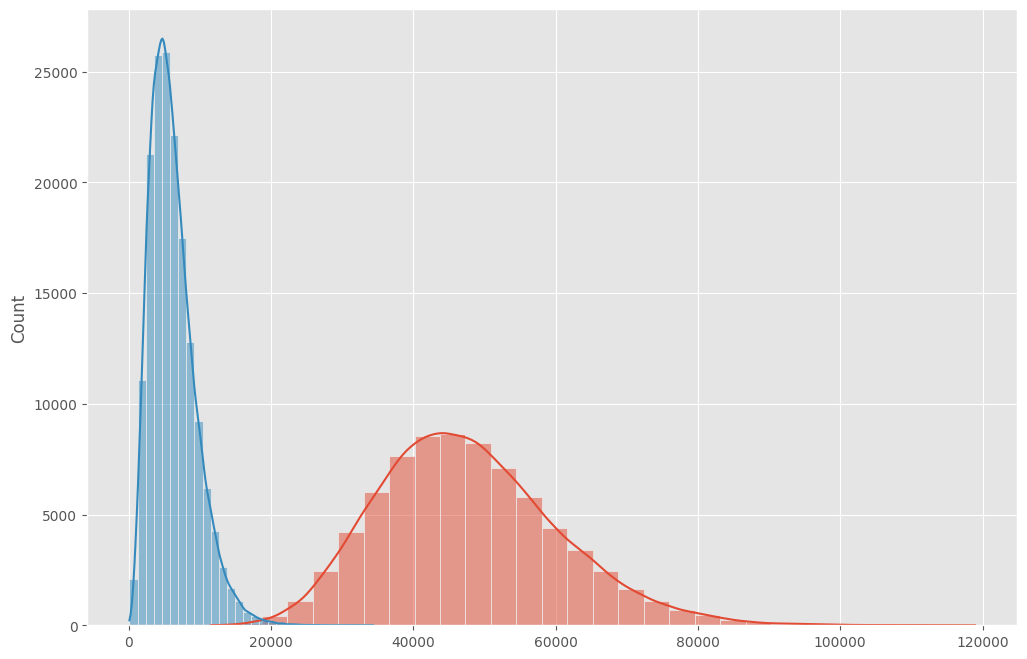

In [53]:
sns.histplot(business, bins=30, kde=True)
sns.histplot(economy, bins=30, kde=True)

plt.show()

In [54]:
pred_gamma([0,1],posterior_samples), pred_gamma([0,1],posterior_samples)

(tensor([79485.7891,  3977.1162]), tensor([31841.6230,  3592.6292]))

In [55]:
posterior_samples['mu'][0]
posterior_samples['sigma'][0]

tensor([0.0003, 0.0006])

In [169]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [57]:
pred_gamma(1,posterior_samples)

tensor(6196.3330)

In [58]:
pred_y = pred_gamma(x_test_clean, posterior_samples)

corr, mae, rae, rmse, r2 = compute_error(y_test_clean.numpy(),pred_y.numpy())

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
#type(pred_y.numpy()), type(y_test_clean.numpy())

CorrCoef: 0.873
MAE: 7311.055
RMSE: 11458.885
R2: 0.743


# adding the airlines into mixing

In [223]:
train_x, test_x, train_y,test_y = train_test_split(business_df[['Economy', 'airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara']], business_df['price'], test_size=0.2, random_state=488)

x_train_clean = torch.tensor(train_x.to_numpy(dtype=np.int_)) #business_df['Economy']
y_train_clean = torch.tensor(train_y.values)

x_test_clean = torch.tensor(test_x.to_numpy(dtype=np.int_)) #business_df['Economy']
y_test_clean = torch.tensor(test_y.values)

In [224]:
x_train_clean[0]

tensor([0, 0, 0, 0, 0, 0, 1])

In [244]:
def first_model(x=None, y=None):
    # priors for components
    airline_count = 6
    mu_scale = torch.tensor([14., 4.] * airline_count).reshape(airline_count,2)
    sigma_scale = torch.tensor([0.006, 0.003])# * airline_count).reshape(airline_count,2)
    #sigma_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        with pyro.plate('airlines',airline_count):
            mu = pyro.sample('mu', pyro.distributions.HalfCauchy(mu_scale))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))
        
    with pyro.plate('data', len(y)):
        buss = x[0] # get if it is business
        airline_index = x[1]
        price = pyro.sample('price', pyro.distributions.Gamma(mu[airline_index,buss],sigma[buss]), obs=y)
    
    return price

In [245]:
x_testing = torch.stack((x_train_clean[:,0],torch.argmax(x_train_clean[:,1:], axis=1)))
x_testing

tensor([[0, 1, 0,  ..., 1, 1, 0],
        [5, 5, 5,  ..., 2, 5, 1]])

In [255]:
# Run inference in Pyro
nuts_kernel = NUTS(first_model)
mcmc = MCMC(nuts_kernel, num_samples=80, warmup_steps=40, num_chains=1)
mcmc.run(x_testing,y_train_clean)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 120/120 [16:56,  8.47s/it, step size=5.52e-04, acc. prob=0.841]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   mu[0,0]      0.36      0.00      0.36      0.36      0.36      3.05      2.13
   mu[0,1]      2.95      0.15      2.86      2.81      3.19      2.80      1.97
   mu[1,0]     15.06      1.46     14.11     13.88     17.84      3.10      1.69
   mu[1,1]      4.96      0.20      4.83      4.77      5.32      2.84      1.94
   mu[2,0]      2.07      0.03      2.08      2.03      2.10      2.45      3.38
   mu[2,1]      4.14      0.22      4.00      3.95      4.52      2.85      1.92
   mu[3,0]      5.37      0.03      5.37      5.32      5.41      9.42      1.01
   mu[3,1]      3.65      0.15      3.55      3.51      3.90      2.80      2.00
   mu[4,0]      3.30      0.03      3.32      3.26      3.34      4.34      1.42
   mu[4,1]      4.50      0.32      4.29      4.21      5.02      2.80      1.98
   mu[5,0]     17.53      1.64     16.47     16.20     20.60      3.10      1.69
   mu[5,1]      5.34      0

In [235]:
def pred(x, post_samples):
    mu = post_samples['mu'].mean(dim=0)
    sigma = post_samples['sigma'].mean(dim=0)
    return pyro.sample('prediction', pyro.distributions.Gamma(mu[x[1],x[0]],sigma[x[1],x[0]]))
    # return pyro.sample('prediction',pyro.distributions.Normal(post_samples['mu'].mean(dim=0)[x],post_samples['sigma'].mean(dim=0)[x]))

In [236]:
posterior_samples = mcmc.get_samples()

In [237]:
x_validate = torch.stack((x_test_clean[:,0],torch.argmax(x_test_clean[:,1:], axis=1)))
pred(x_validate[:,87],posterior_samples)

tensor(59566.9336)

In [238]:
x_validate[:,87]

tensor([0, 1])

In [239]:
pred_y = pred(x_validate, posterior_samples)

corr, mae, rae, rmse, r2 = compute_error(y_test_clean.numpy(),pred_y.numpy())

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.885
MAE: 6869.336
RMSE: 10907.183
R2: 0.767


# using mixing for airlanes as well
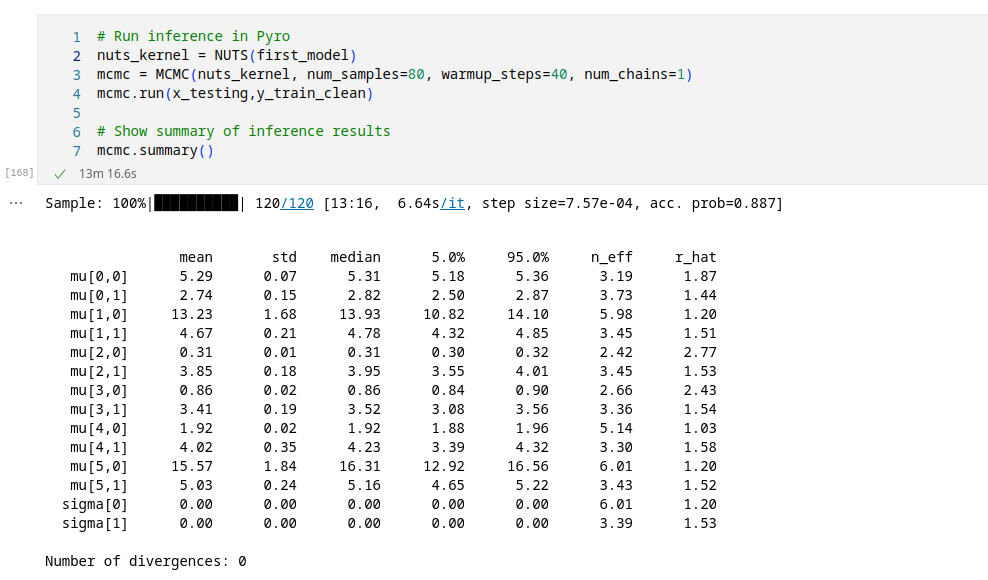

## using both parameter as latent
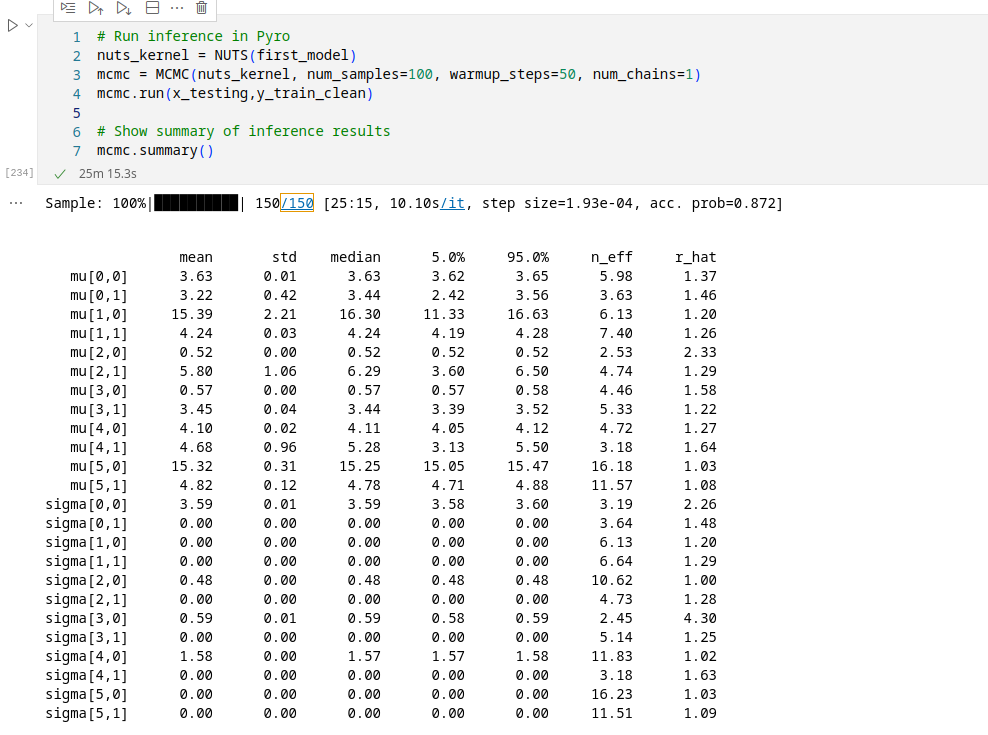

> both of them gives about 0.767 R²

# adding a more specific features on top of class

In [26]:
business_df.columns

Index(['duration', 'days_left', 'price', 'Economy', 'source_size',
       'destination_size', 'departure_time_Afternoon',
       'departure_time_Early_Morning', 'departure_time_Evening',
       'departure_time_Late_Night', 'departure_time_Morning',
       'departure_time_Night', 'arrival_time_Afternoon',
       'arrival_time_Early_Morning', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'stops_num', 'airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara', 'flight_num'],
      dtype='object')

In [18]:
business_df
just_b_df = business_df[business_df['Economy'] == 0]
just_e_df = business_df[business_df['Economy'] == 1]

In [19]:
def show_if_att_correlated(column):
    ax1 = plt.subplot(121)
    ax1.hist2d(just_b_df[column], just_b_df['price'], bins=10)
    ax2 = plt.subplot(122)#, sharey=ax1)
    ax2.hist2d(just_e_df[column], just_e_df['price'], bins=10)
    plt.show()

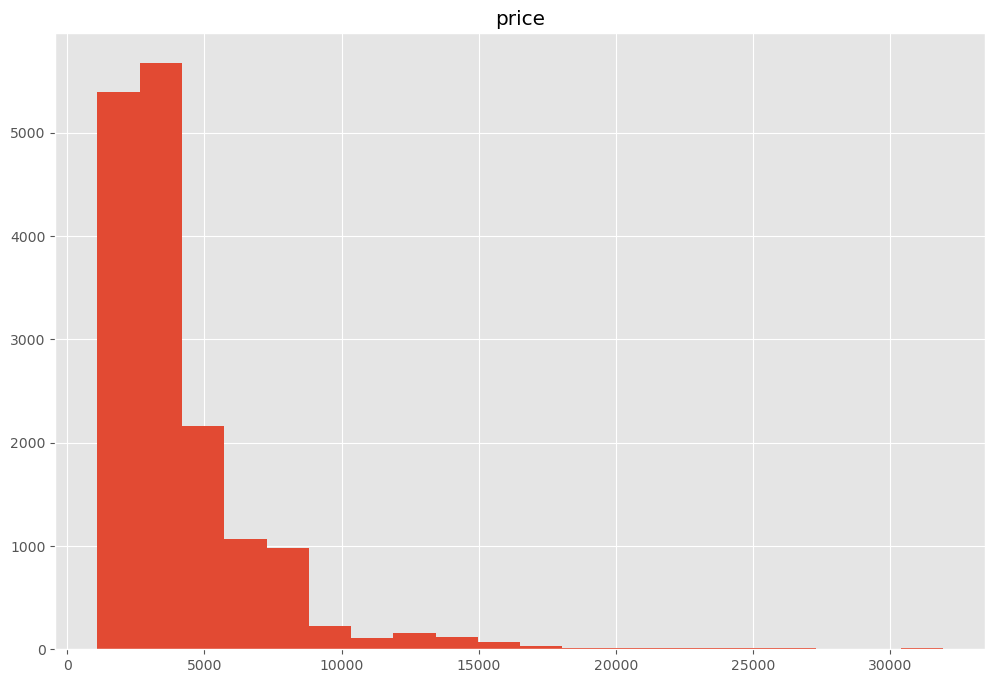

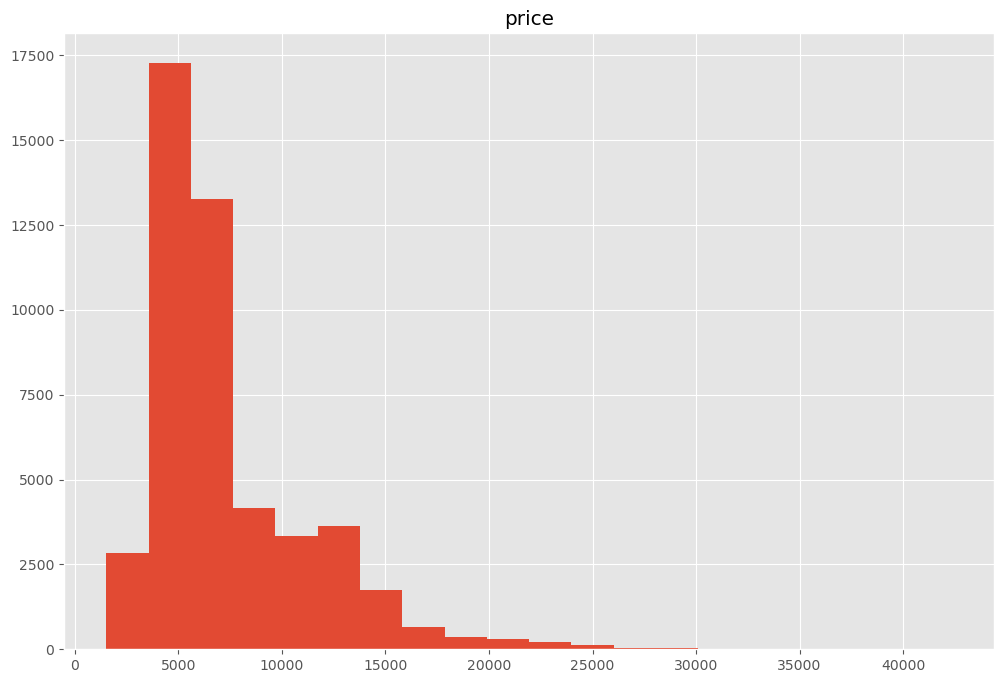

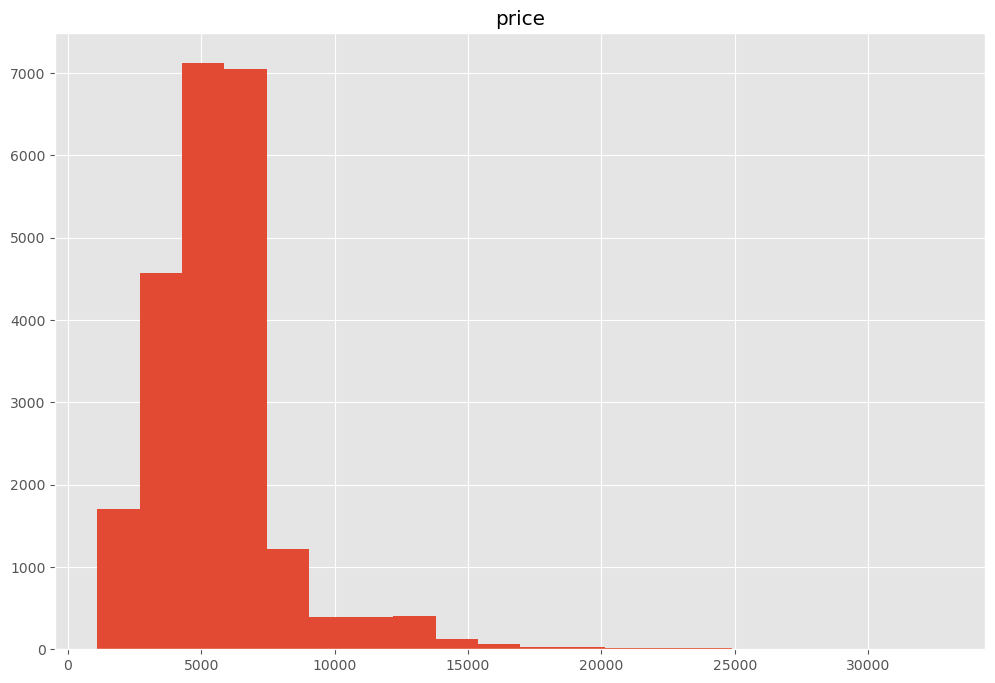

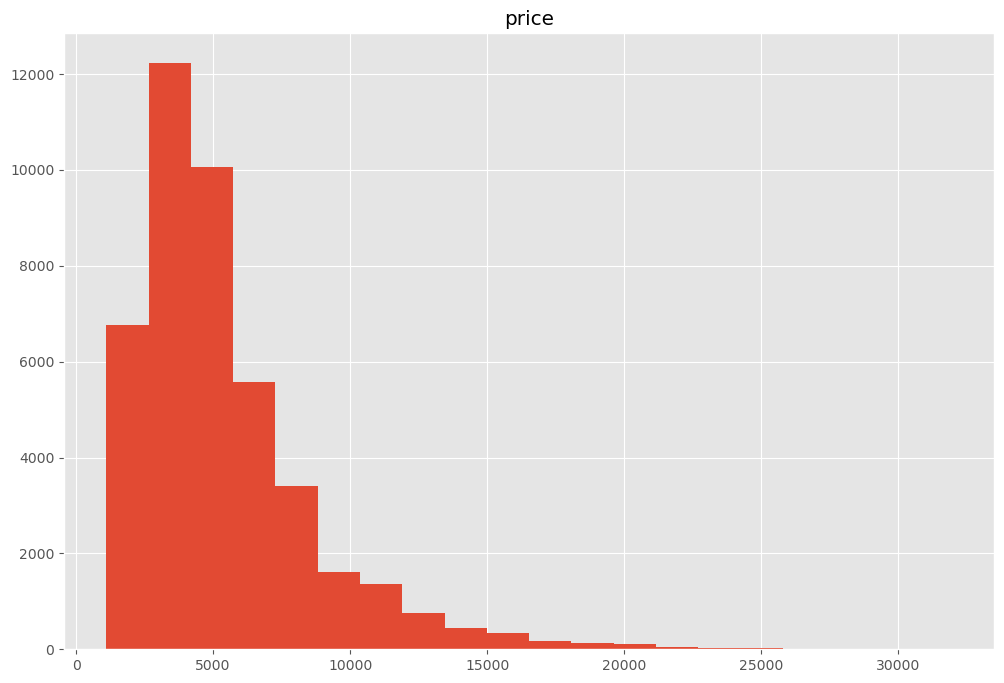

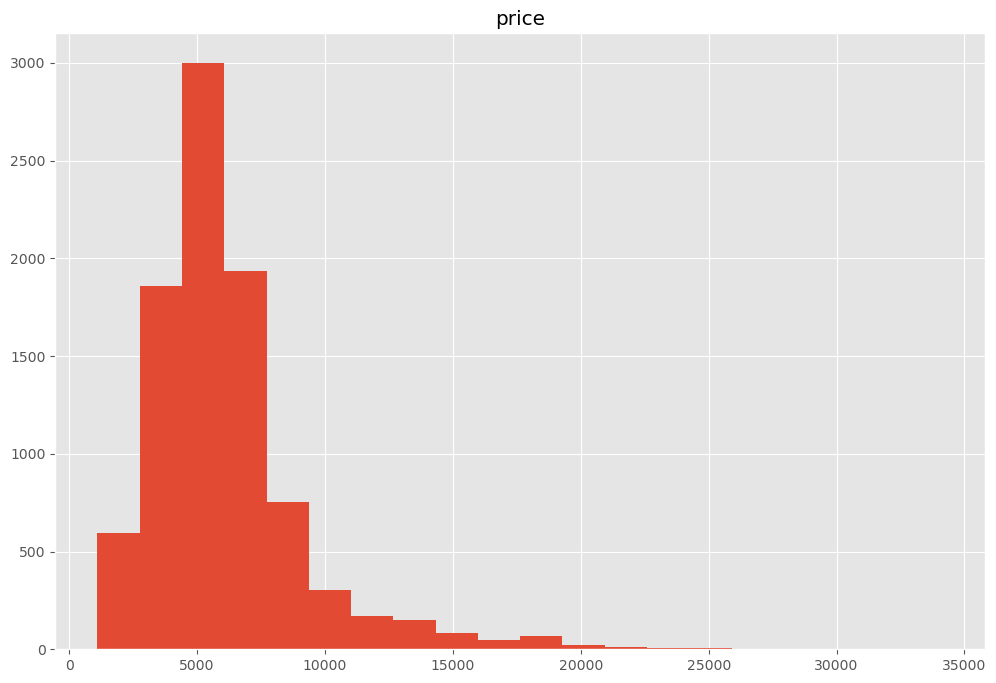

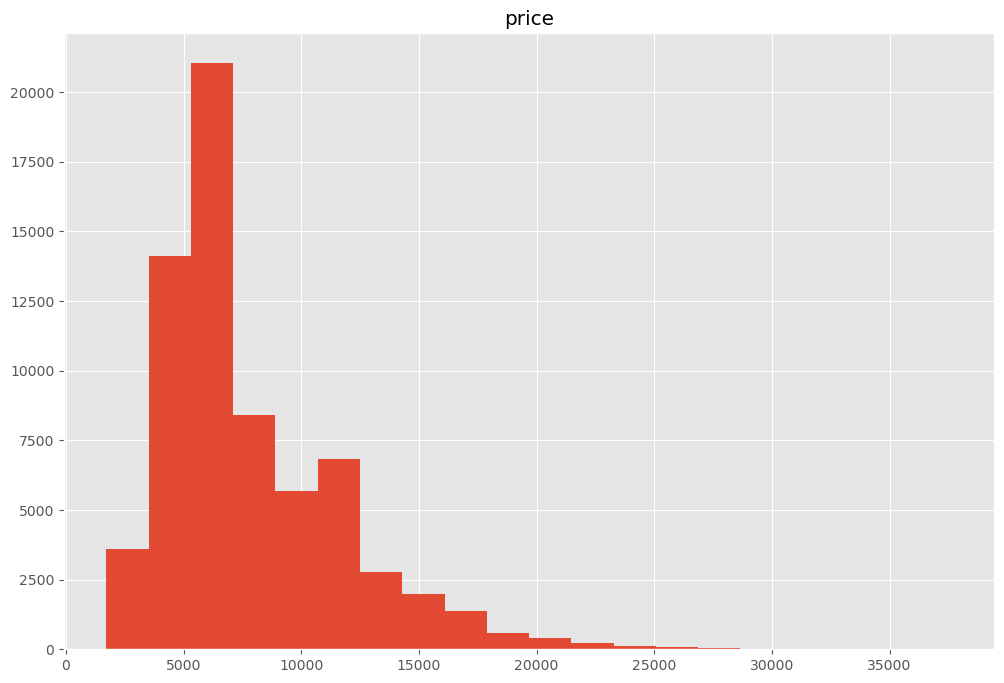

In [36]:
for airline in ['airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara']:
    just_e_df[just_e_df[airline]>0].hist('price', bins=20)

In [43]:
np.argmax(just_e_df[['airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara']].values, axis=1)

array([4, 4, 0, ..., 5, 5, 5])

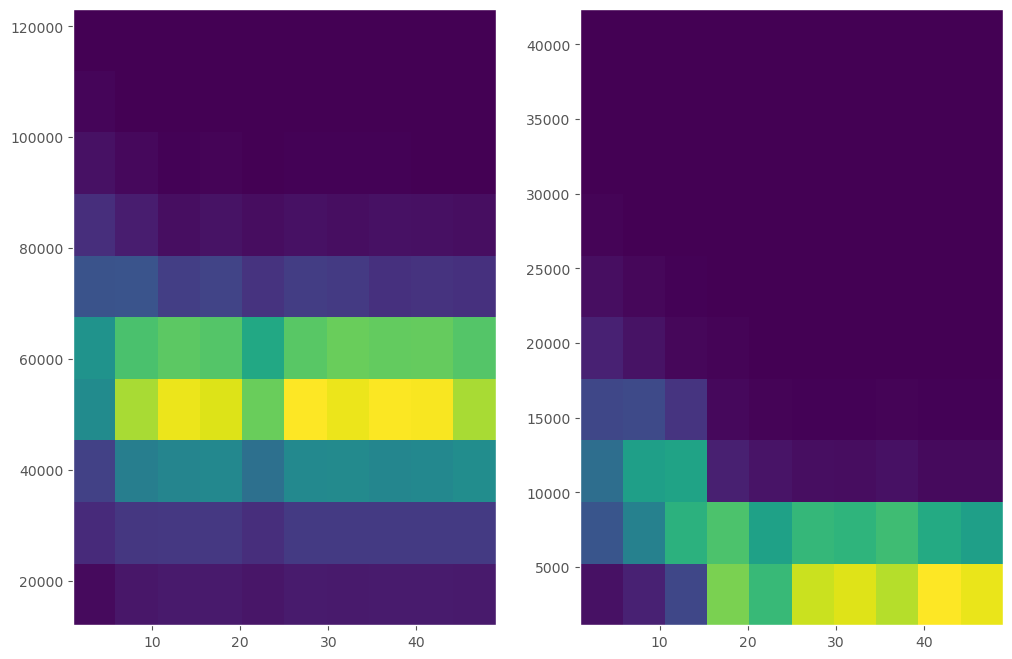

In [20]:
show_if_att_correlated('days_left')

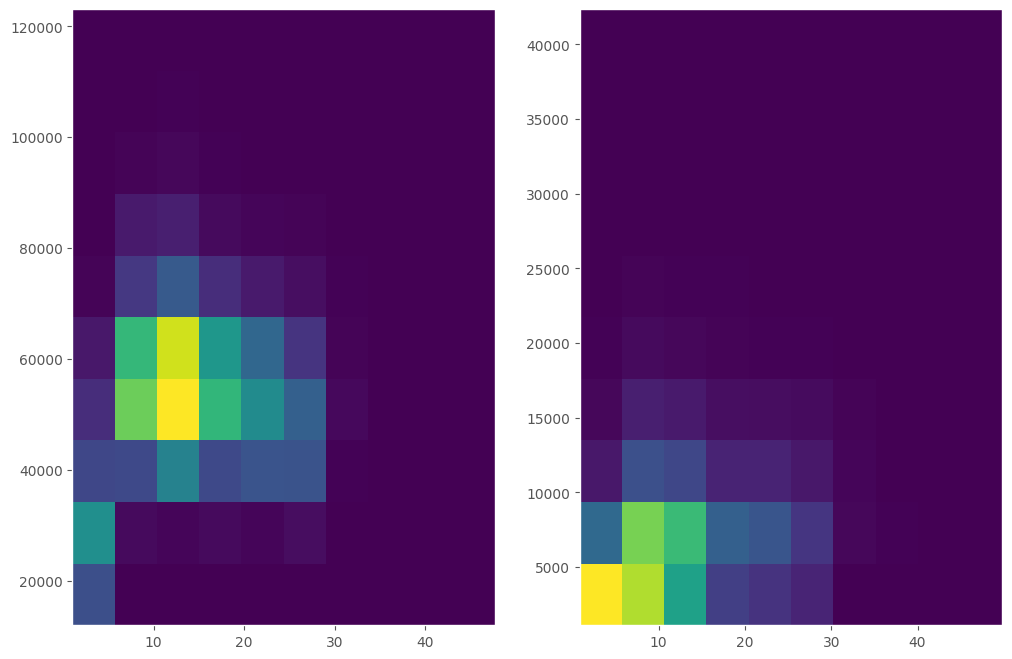

In [100]:
show_if_att_correlated('duration')

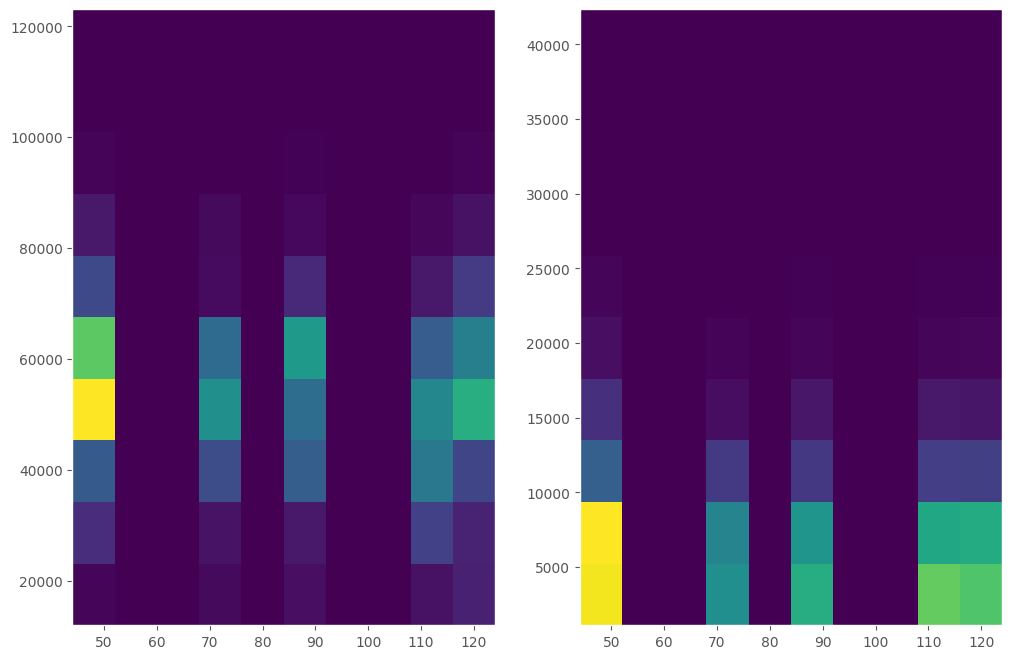

In [101]:
show_if_att_correlated('destination_size')

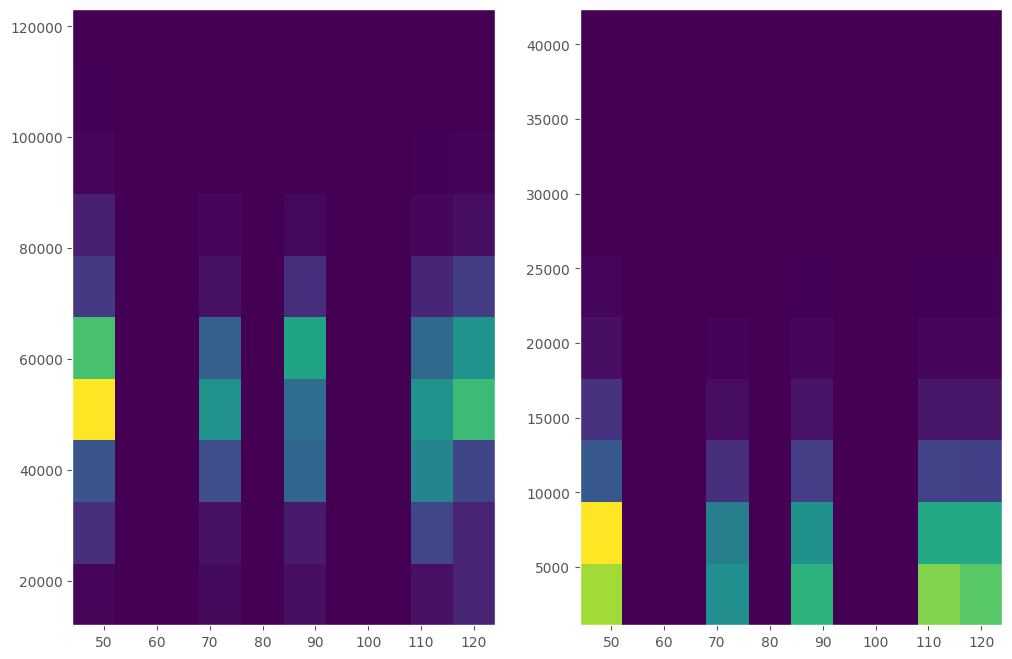

In [102]:
show_if_att_correlated('source_size')

# running pca to get idea as of whst is important

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)

In [7]:
X = business_df.drop('price', inplace=False, axis=1)


In [10]:
X_s = StandardScaler().fit_transform(X)
pcas = PCA(n_components=2)
ress = pcas.fit_transform(X_s)
print(pcas.explained_variance_ratio_)
print('sum:', np.sum(pcas.explained_variance_ratio_))

[0.08848296 0.07741429]
sum: 0.16589724889026464


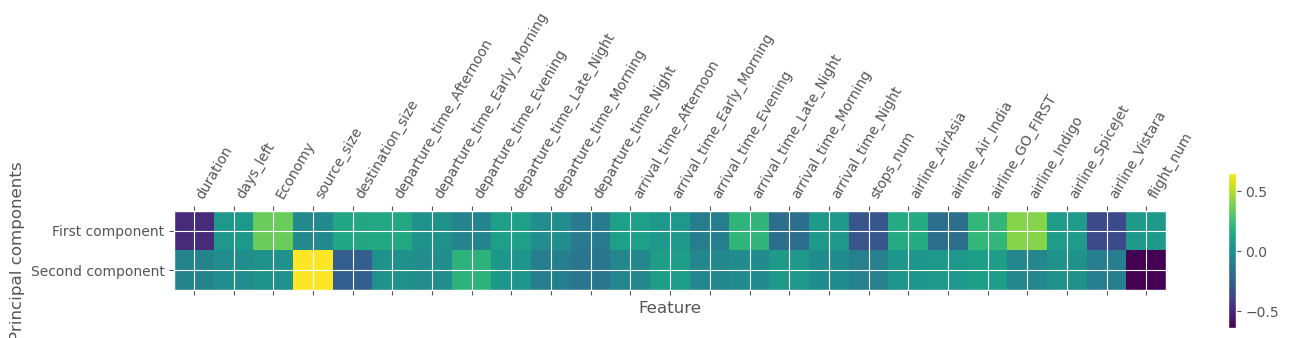

In [11]:
plt.matshow(pcas.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X.columns)),
           X.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")
plt.show()

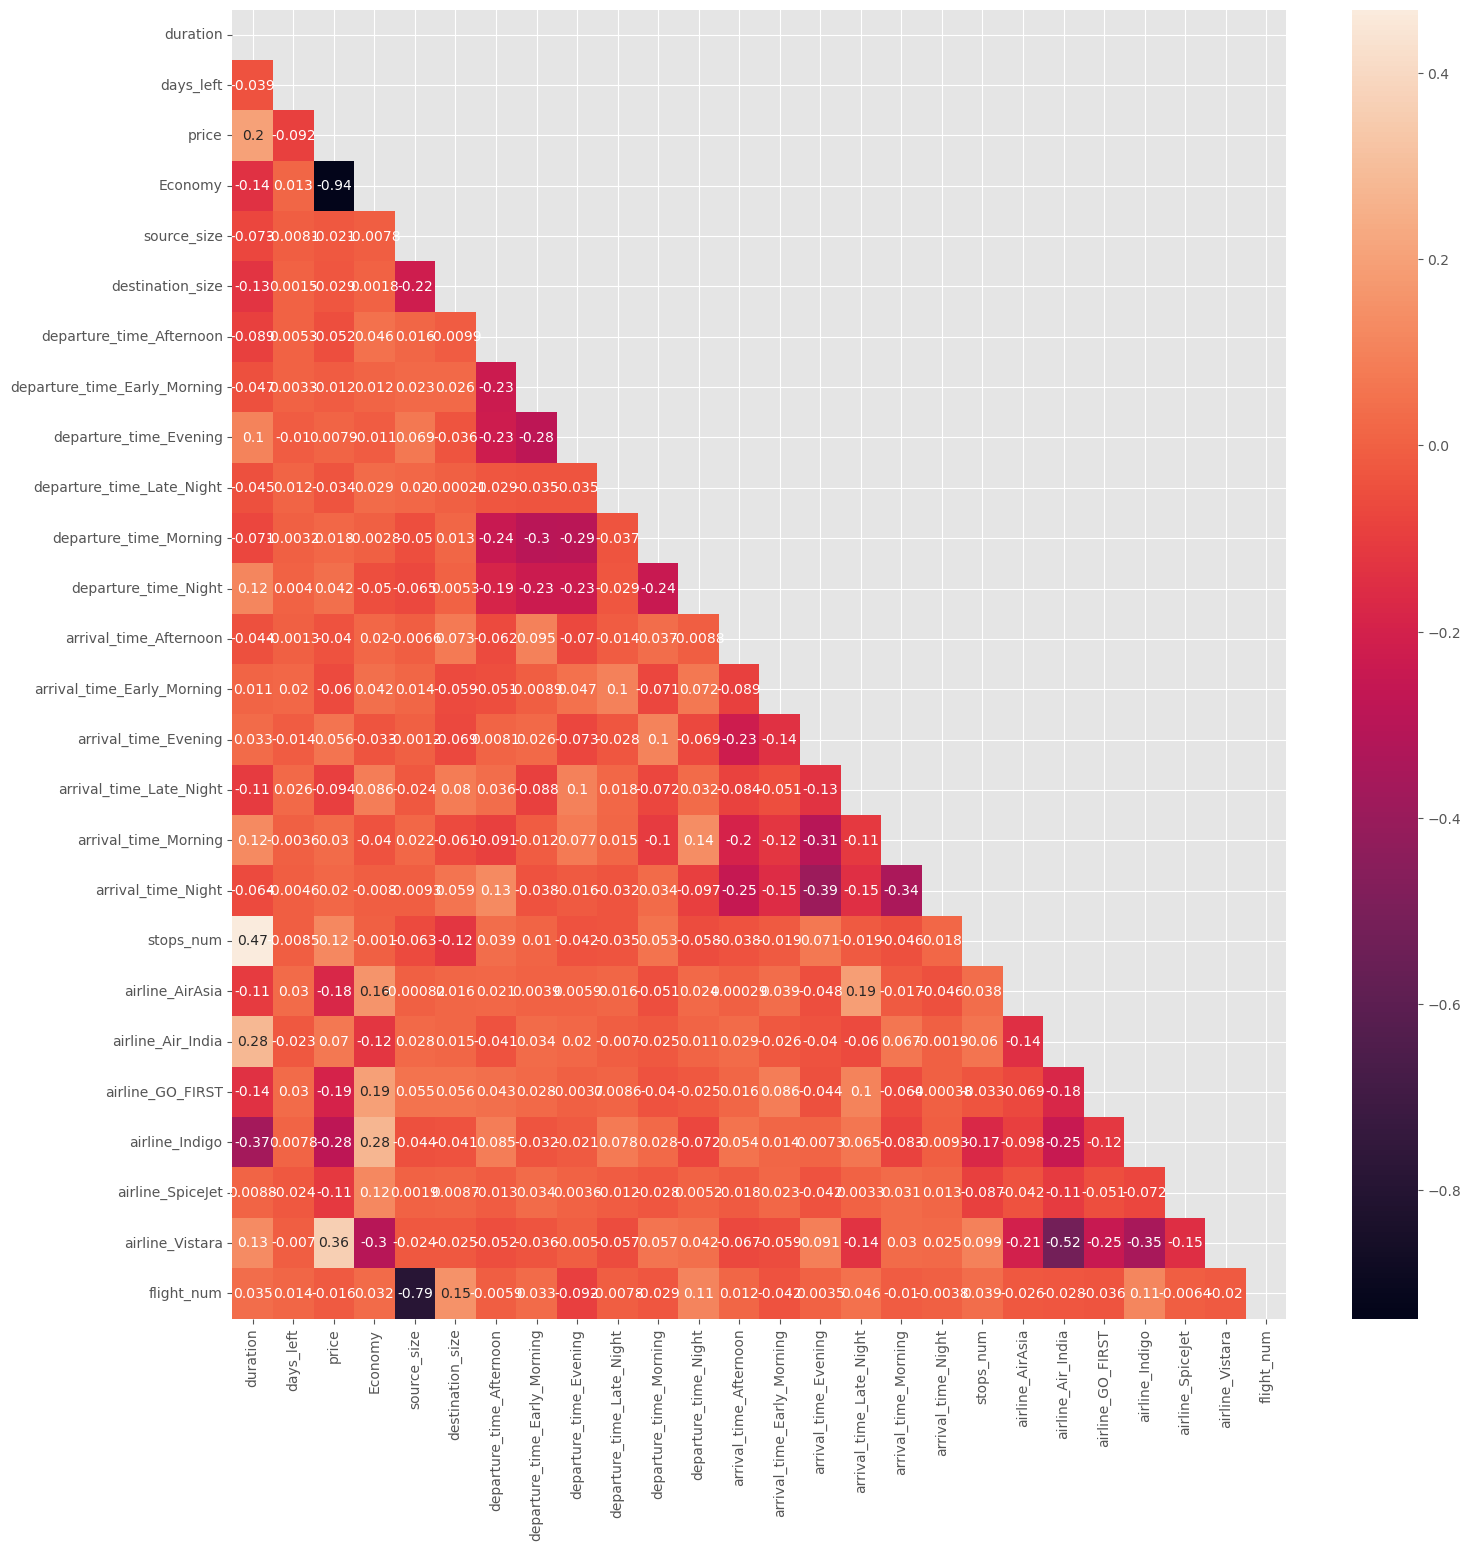

In [16]:
corr_m = business_df.corr()

mask = np.triu(corr_m)
plt.figure(figsize=(17,17))
sns.heatmap(corr_m, annot=True, mask=mask)
plt.show()
